In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
def load_data(img_dir):
    x_data = []
    image_paths = [os.path.join(img_dir, w) for w in os.listdir(img_dir) if w.endswith(".png")]
    for image_path in image_paths:
        img = Image.open(image_path).convert('L')  # Load image in grayscale
        img = img.resize((128, 128))  # Ensure image is 128x128
        x_data.append(np.array(img))
    return np.array(x_data)

# Prepare Data
data = load_data("/home/thumbnails128x128")
data = data.astype('float32') / 255.0

# Add channel dimension
data = data[..., np.newaxis]

# Convert to Tensors and permute to match the expected shape [batch_size, channels, height, width]
data_tensor = torch.tensor(data).float().permute(0, 3, 1, 2).to(device)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calculate the sizes of each split
total_size = len(data_tensor)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

# Shuffle the dataset
indices = torch.randperm(total_size).tolist()

# Split indices for each dataset
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create TensorDataset from shuffled data
train_dataset = TensorDataset(data_tensor[train_indices], data_tensor[train_indices])
val_dataset = TensorDataset(data_tensor[val_indices], data_tensor[val_indices])
test_dataset = TensorDataset(data_tensor[test_indices], data_tensor[test_indices])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the sizes of each dataset
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Using device: cuda
Training set size: 49000
Validation set size: 14000
Test set size: 7000


AE Model

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the AutoEncoder Model
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Training Loop

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_autoencoder(train_loader, val_loader, lambda_1=None, lambda_2=None, model_name=None):
    autoencoder = ConvAutoEncoder().to(device)  # Reinitialize the model for each regularization method
    criterion = nn.MSELoss()

    # Use weight_decay parameter for L2 regularization (if lambda_2 is provided)
    optimizer_params = {'lr': 0.001}
    if lambda_2 is not None:
        optimizer_params['weight_decay'] = lambda_2

    optimizer = optim.Adam(autoencoder.parameters(), **optimizer_params)

    num_epochs = 200
    best_val_loss = float('inf')
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        autoencoder.train()
        epoch_train_loss = 0
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
            for imgs, _ in train_loader:
                imgs = imgs.to(device)  # Move data to device
                outputs = autoencoder(imgs)
                loss = criterion(outputs, imgs)
                
                # Add L1 regularization manually if selected
                if lambda_1 is not None:
                    l1_norm = sum(p.abs().sum() for p in autoencoder.parameters())
                    loss += lambda_1 * l1_norm

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_train_loss += loss.item() * imgs.size(0)
                pbar.set_postfix(loss=loss.item())
                pbar.update()

        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Average Loss: {avg_train_loss:.5f}")
        
        # Validation phase
        autoencoder.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for imgs, _ in val_loader:
                imgs = imgs.to(device)  # Move data to device
                outputs = autoencoder(imgs)
                loss = criterion(outputs, imgs)
                epoch_val_loss += loss.item() * imgs.size(0)
        
        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Average Loss: {avg_val_loss:.5f}")

        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = autoencoder.state_dict()

    # Save the best model for this regularization setting
    if best_model_state is not None:
        torch.save(best_model_state, f'./autoencoder_best_{model_name}.pth')
        print(f"Best model for {model_name} saved with val loss {best_val_loss:.5f}")

    return train_losses, val_losses

def plot_losses(losses_dict):

    # Training Loss Plot
    #plt.subplot(2, 1, 1)
    plt.figure(figsize=(6,4))
    for label, losses in losses_dict['train'].items():
        plt.plot(losses, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Comparison with Different Regularization Settings')
    plt.legend(loc='upper right')  # Place legend in the upper-right corner
    plt.grid(True)

    # Validation Loss Plot
    #plt.subplot(2, 1, 2)
    plt.figure(figsize=(6,4))
    for label, losses in losses_dict['val'].items():
        plt.plot(losses, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison with Different Regularization Settings')
    plt.legend(loc='upper right')  # Place legend in the upper-right corner
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [4]:

lambda_1 = 1e-5
lambda_2 = 1e-5

train_losses = {}
val_losses = {}

# Train and save models with different regularization methods
train_losses['No Reg'], val_losses['No Reg'] = train_autoencoder(
    train_loader, val_loader, model_name='no_reg'
)
train_losses['L2'], val_losses['L2'] = train_autoencoder(
    train_loader, val_loader, lambda_2=lambda_2, model_name='l2_reg'
)
train_losses['L1'], val_losses['L1'] = train_autoencoder(
    train_loader, val_loader, lambda_1=lambda_1, model_name='l1_reg'
)
train_losses['L1 + L2'], val_losses['L1 + L2'] = train_autoencoder(
    train_loader, val_loader, lambda_1=lambda_1, lambda_2=lambda_2, model_name='l1_l2_reg'
)

# Plot all losses
plot_losses({
    'train': train_losses,
    'val': val_losses
})


Epoch 1/200:   0%|          | 0/383 [00:00<?, ?batch/s]

Epoch 1/200: 100%|██████████| 383/383 [00:01<00:00, 278.43batch/s, loss=0.00411]


Epoch [1/200], Training Average Loss: 0.02076
Epoch [1/200], Validation Average Loss: 0.00409


Epoch 2/200: 100%|██████████| 383/383 [00:01<00:00, 299.43batch/s, loss=0.00328]


Epoch [2/200], Training Average Loss: 0.00358
Epoch [2/200], Validation Average Loss: 0.00325


Epoch 3/200: 100%|██████████| 383/383 [00:01<00:00, 301.60batch/s, loss=0.00266]


Epoch [3/200], Training Average Loss: 0.00304
Epoch [3/200], Validation Average Loss: 0.00286


Epoch 4/200: 100%|██████████| 383/383 [00:01<00:00, 302.23batch/s, loss=0.00269]


Epoch [4/200], Training Average Loss: 0.00272
Epoch [4/200], Validation Average Loss: 0.00260


Epoch 5/200: 100%|██████████| 383/383 [00:01<00:00, 302.64batch/s, loss=0.00227]


Epoch [5/200], Training Average Loss: 0.00245
Epoch [5/200], Validation Average Loss: 0.00233


Epoch 6/200: 100%|██████████| 383/383 [00:01<00:00, 297.22batch/s, loss=0.00224]


Epoch [6/200], Training Average Loss: 0.00227
Epoch [6/200], Validation Average Loss: 0.00220


Epoch 7/200: 100%|██████████| 383/383 [00:01<00:00, 304.32batch/s, loss=0.00199]


Epoch [7/200], Training Average Loss: 0.00216
Epoch [7/200], Validation Average Loss: 0.00211


Epoch 8/200: 100%|██████████| 383/383 [00:01<00:00, 302.67batch/s, loss=0.0018] 


Epoch [8/200], Training Average Loss: 0.00199
Epoch [8/200], Validation Average Loss: 0.00178


Epoch 9/200: 100%|██████████| 383/383 [00:01<00:00, 299.70batch/s, loss=0.00164]


Epoch [9/200], Training Average Loss: 0.00172
Epoch [9/200], Validation Average Loss: 0.00166


Epoch 10/200: 100%|██████████| 383/383 [00:01<00:00, 302.12batch/s, loss=0.00163]


Epoch [10/200], Training Average Loss: 0.00164
Epoch [10/200], Validation Average Loss: 0.00160


Epoch 11/200: 100%|██████████| 383/383 [00:01<00:00, 302.42batch/s, loss=0.00155]


Epoch [11/200], Training Average Loss: 0.00159
Epoch [11/200], Validation Average Loss: 0.00156


Epoch 12/200: 100%|██████████| 383/383 [00:01<00:00, 301.76batch/s, loss=0.00152]


Epoch [12/200], Training Average Loss: 0.00155
Epoch [12/200], Validation Average Loss: 0.00153


Epoch 13/200: 100%|██████████| 383/383 [00:01<00:00, 301.25batch/s, loss=0.00145]


Epoch [13/200], Training Average Loss: 0.00152
Epoch [13/200], Validation Average Loss: 0.00150


Epoch 14/200: 100%|██████████| 383/383 [00:01<00:00, 301.50batch/s, loss=0.00148]


Epoch [14/200], Training Average Loss: 0.00150
Epoch [14/200], Validation Average Loss: 0.00147


Epoch 15/200: 100%|██████████| 383/383 [00:01<00:00, 297.38batch/s, loss=0.00156]


Epoch [15/200], Training Average Loss: 0.00148
Epoch [15/200], Validation Average Loss: 0.00146


Epoch 16/200: 100%|██████████| 383/383 [00:01<00:00, 301.07batch/s, loss=0.00149]


Epoch [16/200], Training Average Loss: 0.00146
Epoch [16/200], Validation Average Loss: 0.00144


Epoch 17/200: 100%|██████████| 383/383 [00:01<00:00, 300.25batch/s, loss=0.00139]


Epoch [17/200], Training Average Loss: 0.00144
Epoch [17/200], Validation Average Loss: 0.00142


Epoch 18/200: 100%|██████████| 383/383 [00:01<00:00, 299.08batch/s, loss=0.00152]


Epoch [18/200], Training Average Loss: 0.00143
Epoch [18/200], Validation Average Loss: 0.00141


Epoch 19/200: 100%|██████████| 383/383 [00:01<00:00, 298.09batch/s, loss=0.0013] 


Epoch [19/200], Training Average Loss: 0.00142
Epoch [19/200], Validation Average Loss: 0.00141


Epoch 20/200: 100%|██████████| 383/383 [00:01<00:00, 299.38batch/s, loss=0.00153]


Epoch [20/200], Training Average Loss: 0.00141
Epoch [20/200], Validation Average Loss: 0.00139


Epoch 21/200: 100%|██████████| 383/383 [00:01<00:00, 301.24batch/s, loss=0.00136]


Epoch [21/200], Training Average Loss: 0.00140
Epoch [21/200], Validation Average Loss: 0.00140


Epoch 22/200: 100%|██████████| 383/383 [00:01<00:00, 300.08batch/s, loss=0.00147]


Epoch [22/200], Training Average Loss: 0.00139
Epoch [22/200], Validation Average Loss: 0.00138


Epoch 23/200: 100%|██████████| 383/383 [00:01<00:00, 298.71batch/s, loss=0.00139]


Epoch [23/200], Training Average Loss: 0.00138
Epoch [23/200], Validation Average Loss: 0.00136


Epoch 24/200: 100%|██████████| 383/383 [00:01<00:00, 300.20batch/s, loss=0.00131]


Epoch [24/200], Training Average Loss: 0.00137
Epoch [24/200], Validation Average Loss: 0.00136


Epoch 25/200: 100%|██████████| 383/383 [00:01<00:00, 297.36batch/s, loss=0.00131]


Epoch [25/200], Training Average Loss: 0.00137
Epoch [25/200], Validation Average Loss: 0.00135


Epoch 26/200: 100%|██████████| 383/383 [00:01<00:00, 295.93batch/s, loss=0.00136]


Epoch [26/200], Training Average Loss: 0.00136
Epoch [26/200], Validation Average Loss: 0.00134


Epoch 27/200: 100%|██████████| 383/383 [00:01<00:00, 296.57batch/s, loss=0.00124]


Epoch [27/200], Training Average Loss: 0.00135
Epoch [27/200], Validation Average Loss: 0.00134


Epoch 28/200: 100%|██████████| 383/383 [00:01<00:00, 297.71batch/s, loss=0.00136]


Epoch [28/200], Training Average Loss: 0.00135
Epoch [28/200], Validation Average Loss: 0.00134


Epoch 29/200: 100%|██████████| 383/383 [00:01<00:00, 298.05batch/s, loss=0.00141]


Epoch [29/200], Training Average Loss: 0.00134
Epoch [29/200], Validation Average Loss: 0.00133


Epoch 30/200: 100%|██████████| 383/383 [00:01<00:00, 295.95batch/s, loss=0.00139]


Epoch [30/200], Training Average Loss: 0.00134
Epoch [30/200], Validation Average Loss: 0.00133


Epoch 31/200: 100%|██████████| 383/383 [00:01<00:00, 299.59batch/s, loss=0.00138]


Epoch [31/200], Training Average Loss: 0.00134
Epoch [31/200], Validation Average Loss: 0.00132


Epoch 32/200: 100%|██████████| 383/383 [00:01<00:00, 299.38batch/s, loss=0.00148]


Epoch [32/200], Training Average Loss: 0.00133
Epoch [32/200], Validation Average Loss: 0.00132


Epoch 33/200: 100%|██████████| 383/383 [00:01<00:00, 299.15batch/s, loss=0.00135]


Epoch [33/200], Training Average Loss: 0.00133
Epoch [33/200], Validation Average Loss: 0.00132


Epoch 34/200: 100%|██████████| 383/383 [00:01<00:00, 296.78batch/s, loss=0.00144]


Epoch [34/200], Training Average Loss: 0.00133
Epoch [34/200], Validation Average Loss: 0.00131


Epoch 35/200: 100%|██████████| 383/383 [00:01<00:00, 296.50batch/s, loss=0.00137]


Epoch [35/200], Training Average Loss: 0.00132
Epoch [35/200], Validation Average Loss: 0.00131


Epoch 36/200: 100%|██████████| 383/383 [00:01<00:00, 291.73batch/s, loss=0.00128]


Epoch [36/200], Training Average Loss: 0.00132
Epoch [36/200], Validation Average Loss: 0.00131


Epoch 37/200: 100%|██████████| 383/383 [00:01<00:00, 297.25batch/s, loss=0.00136]


Epoch [37/200], Training Average Loss: 0.00132
Epoch [37/200], Validation Average Loss: 0.00130


Epoch 38/200: 100%|██████████| 383/383 [00:01<00:00, 297.81batch/s, loss=0.00117]


Epoch [38/200], Training Average Loss: 0.00131
Epoch [38/200], Validation Average Loss: 0.00130


Epoch 39/200: 100%|██████████| 383/383 [00:01<00:00, 299.37batch/s, loss=0.00134]


Epoch [39/200], Training Average Loss: 0.00131
Epoch [39/200], Validation Average Loss: 0.00130


Epoch 40/200: 100%|██████████| 383/383 [00:01<00:00, 292.90batch/s, loss=0.00132]


Epoch [40/200], Training Average Loss: 0.00131
Epoch [40/200], Validation Average Loss: 0.00130


Epoch 41/200: 100%|██████████| 383/383 [00:01<00:00, 297.65batch/s, loss=0.00121]


Epoch [41/200], Training Average Loss: 0.00131
Epoch [41/200], Validation Average Loss: 0.00130


Epoch 42/200: 100%|██████████| 383/383 [00:01<00:00, 297.47batch/s, loss=0.00128]


Epoch [42/200], Training Average Loss: 0.00130
Epoch [42/200], Validation Average Loss: 0.00129


Epoch 43/200: 100%|██████████| 383/383 [00:01<00:00, 293.60batch/s, loss=0.00134]


Epoch [43/200], Training Average Loss: 0.00130
Epoch [43/200], Validation Average Loss: 0.00130


Epoch 44/200: 100%|██████████| 383/383 [00:01<00:00, 286.00batch/s, loss=0.00123]


Epoch [44/200], Training Average Loss: 0.00130
Epoch [44/200], Validation Average Loss: 0.00131


Epoch 45/200: 100%|██████████| 383/383 [00:01<00:00, 293.44batch/s, loss=0.00126]


Epoch [45/200], Training Average Loss: 0.00130
Epoch [45/200], Validation Average Loss: 0.00131


Epoch 46/200: 100%|██████████| 383/383 [00:01<00:00, 293.35batch/s, loss=0.0012] 


Epoch [46/200], Training Average Loss: 0.00130
Epoch [46/200], Validation Average Loss: 0.00128


Epoch 47/200: 100%|██████████| 383/383 [00:01<00:00, 294.17batch/s, loss=0.00123]


Epoch [47/200], Training Average Loss: 0.00129
Epoch [47/200], Validation Average Loss: 0.00128


Epoch 48/200:  40%|████      | 155/383 [00:00<00:00, 296.09batch/s, loss=0.00127]

Compression ratio

In [ ]:

# Function to calculate and print compression ratio
def calculate_compression_ratio(model_name):
    autoencoder = ConvAutoEncoder().to(device)
    autoencoder.load_state_dict(torch.load(f'./{model_name}.pth', map_location=device))
    autoencoder.eval()
    
    original_size = data_tensor.numel()  # Total number of elements
    model_size = sum(p.numel() for p in autoencoder.parameters())
    compression_ratio = model_size / original_size
    
    print(f"Compression Ratio for {model_name}: {compression_ratio:.4f}")


In [ ]:
calculate_compression_ratio('autoencoder_best_no_reg')

Compression Ratio for autoencoder_best_no_reg: 0.0000


Evaluation Matrices

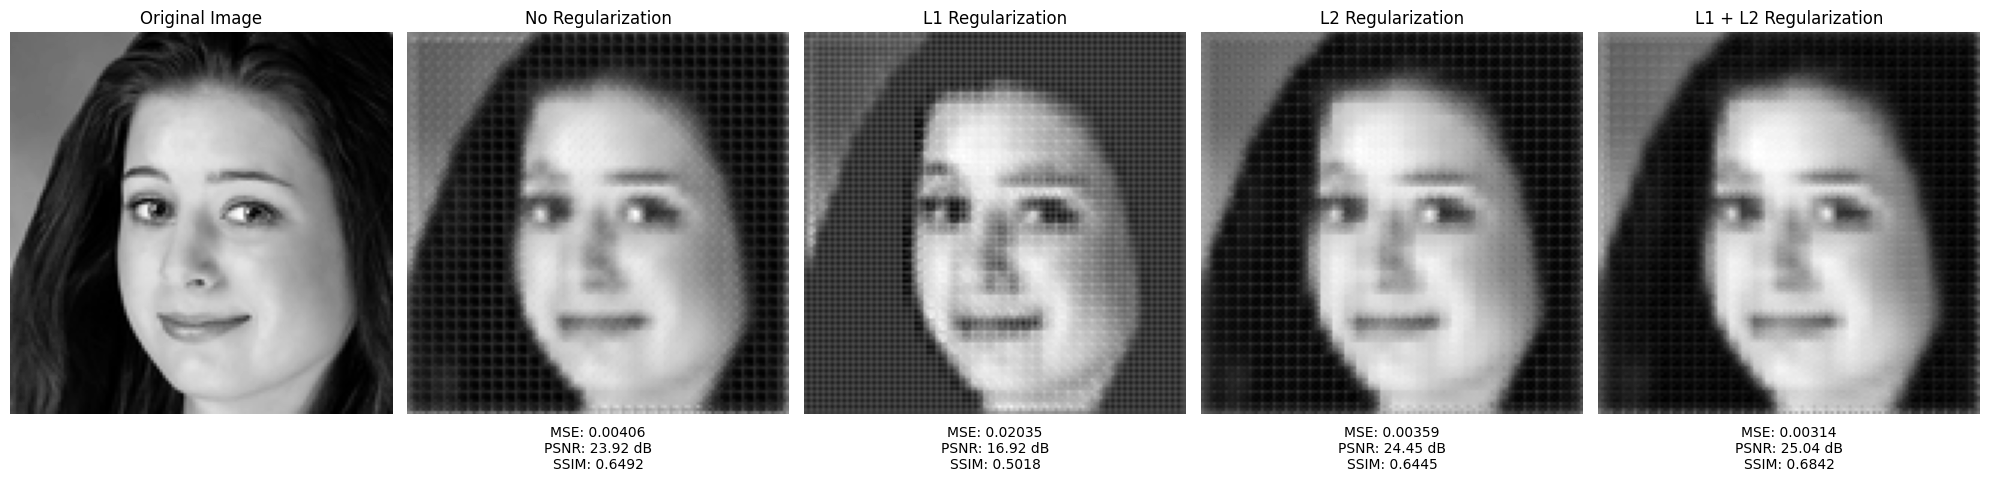

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim

def calculate_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

def calculate_psnr(mse, max_pixel=1.0):
    if mse == 0:
        return float('inf')
    return 10 * np.log10(max_pixel ** 2 / mse)

def plot_single_image_reconstructions(image_index, model_paths, titles, test_loader):
    # Get a batch of test images
    images, _ = next(iter(test_loader))  # Get a batch from the test loader
    images = images.to(device)  # Move to device
    
    # Select the image to be reconstructed
    original_img = images[image_index].cpu().numpy()

    # Initialize the plot
    fig, axes = plt.subplots(1, len(model_paths) + 1, figsize=(20, 5))
    
    # Plot the original image
    axes[0].imshow(original_img[0], cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Original Image')
    
    for i, (model_path, title) in enumerate(zip(model_paths, titles), start=1):
        # Load and evaluate the model
        model = ConvAutoEncoder().to(device)
        model.load_state_dict(torch.load(f'./{model_path}.pth'))
        model.eval()
        
        # Reconstruct the image
        with torch.no_grad():
            img_tensor = images[image_index].unsqueeze(0).to(device)
            reconstructed_img = model(img_tensor).cpu().numpy()[0]
        
        # Calculate metrics
        mse_value = calculate_mse(original_img, reconstructed_img)
        psnr_value = calculate_psnr(mse_value)
        ssim_value = ssim(original_img[0], reconstructed_img[0], data_range=1.0)
        
        # Plot reconstructed image
        axes[i].imshow(reconstructed_img[0], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(title)
        
        # Add MSE, PSNR, and SSIM text without additional gap
        axes[i].text(0.5, -0.03, 
                     f'MSE: {mse_value:.5f}\nPSNR: {psnr_value:.2f} dB\nSSIM: {ssim_value:.4f}', 
                     ha='center', va='top', transform=axes[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.75,edgecolor='none'))
    
    plt.tight_layout()
    plt.show()

# Example usage
model_paths = [
    'autoencoder_best_no_reg',
    'autoencoder_best_l1_reg',
    'autoencoder_best_l2_reg',
    'autoencoder_best_l1_l2_reg'
]
titles = [
    'No Regularization',
    'L1 Regularization',
    'L2 Regularization',
    'L1 + L2 Regularization'
]

# Plot for a specific image index, e.g., 0
plot_single_image_reconstructions(0, model_paths, titles, test_loader)


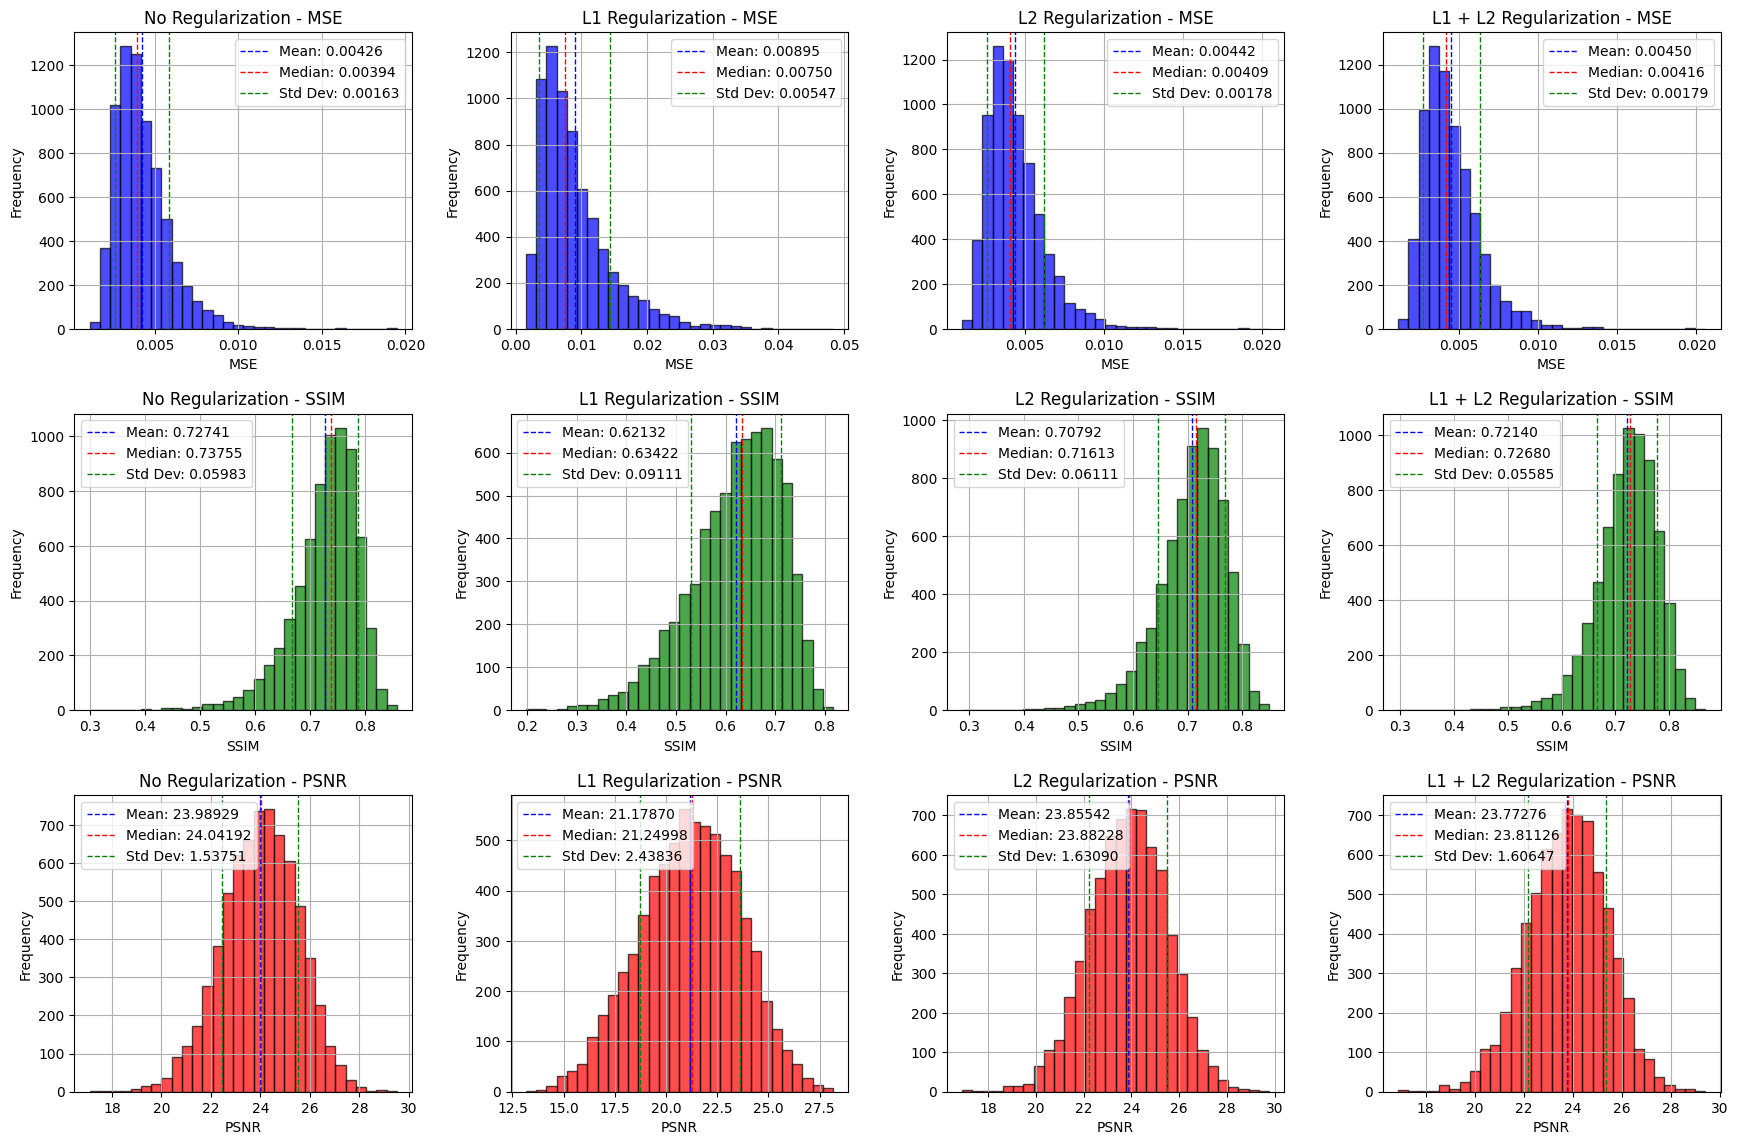

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of model paths and titles for plots
model_paths = [
    'autoencoder_best_no_reg',
    'autoencoder_best_l1_reg',
    'autoencoder_best_l2_reg',
    'autoencoder_best_l1_l2_reg'
]
titles = [
    'No Regularization',
    'L1 Regularization',
    'L2 Regularization',
    'L1 + L2 Regularization'
]

#Function to plot histograms with mean, median, and std dev lines
def plot_histogram_with_stats(ax, data, color, xlabel, ylabel):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)

    ax.hist(data, bins=30, color=color, edgecolor='black', alpha=0.7)
    ax.axvline(mean, color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.5f}')
    ax.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.5f}')
    ax.axvline(mean + std, color='green', linestyle='dashed', linewidth=1, label=f'Std Dev: {std:.5f}')
    ax.axvline(mean - std, color='green', linestyle='dashed', linewidth=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)
    
# Function to calculate metrics
def calculate_metrics(original_images, reconstructed_images):
    mse_list = []
    ssim_list = []
    psnr_list = []
    
    for i in range(original_images.shape[0]):  # Assuming batch size is first dimension
        original_img = original_images[i].squeeze()  # Remove channel dimension
        reconstructed_img = reconstructed_images[i].squeeze()  # Remove channel dimension

        # Calculate MSE
        mse = mean_squared_error(original_img.flatten(), reconstructed_img.flatten())
        mse_list.append(mse)
        
        # Calculate SSIM
        ssim_value = ssim(original_img, reconstructed_img, data_range=1.0)  # Adjust data_range as needed
        ssim_list.append(ssim_value)
        
        # Calculate PSNR
        psnr_value = psnr(original_img, reconstructed_img, data_range=1.0)  # Adjust data_range as needed
        psnr_list.append(psnr_value)
    
    return mse_list, ssim_list, psnr_list

# Create a figure with subplots for each model
fig, axes = plt.subplots(3, len(model_paths), figsize=(18, 12))
fig.tight_layout(pad=4.0)

for idx, (model_path, title) in enumerate(zip(model_paths, titles)):
    # Initialize lists to store metrics for this model
    mse_list = []
    ssim_list = []
    psnr_list = []

    # Load and evaluate the model
    model = ConvAutoEncoder().to(device)
    model.load_state_dict(torch.load(f'./{model_path}.pth'))
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            images, _ = batch
            images = images.to(device)  # Images should already be in shape (batch_size, channels, height, width)
            
            # Reconstruct images
            reconstructed_images = model(images)  # Adjust according to your ConvAutoEncoder output
            
            # Convert images and reconstructed images to numpy arrays
            original_images = images.cpu().numpy()  # Shape should be (batch_size, 1, height, width)
            reconstructed_images = reconstructed_images.cpu().numpy()  # Shape should be (batch_size, 1, height, width)

            # Calculate metrics
            mse, ssim_values, psnr_values = calculate_metrics(original_images, reconstructed_images)
            mse_list.extend(mse)
            ssim_list.extend(ssim_values)
            psnr_list.extend(psnr_values)

    # Ensure all lists have the same length
    min_length = min(len(mse_list), len(ssim_list), len(psnr_list))
    mse_list = mse_list[:min_length]
    ssim_list = ssim_list[:min_length]
    psnr_list = psnr_list[:min_length]

    # Plot histograms for MSE, SSIM, and PSNR in respective rows
    ax_mse = axes[0, idx]
    ax_ssim = axes[1, idx]
    ax_psnr = axes[2, idx]

    # MSE Plot
    plot_histogram_with_stats(ax_mse, mse_list, 'blue', 'MSE', 'Frequency')
    ax_mse.set_title(f'{title} - MSE')

    # SSIM Plot
    plot_histogram_with_stats(ax_ssim, ssim_list, 'green', 'SSIM', 'Frequency')
    ax_ssim.set_title(f'{title} - SSIM')

    # PSNR Plot
    plot_histogram_with_stats(ax_psnr, psnr_list, 'red', 'PSNR', 'Frequency')
    ax_psnr.set_title(f'{title} - PSNR')

plt.show()  # Display the combined plot


Noisy Data

In [ ]:
def add_gaussian_noise(image, mean=0, std=0.1):
    """
    Add Gaussian noise to the input image.
    
    Parameters:
    - image: The input image (numpy array or PyTorch tensor).
    - mean: Mean of the Gaussian noise.
    - std: Standard deviation of the Gaussian noise.
    
    Returns:
    - Noisy image.
    """
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()  # Convert to numpy array if it's a tensor
    
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_image = image + noise
    
    # Clip the values to be in the valid range (0-1 for normalized images)
    noisy_image = np.clip(noisy_image, 0, 1)
    
    if isinstance(image, torch.Tensor):
        noisy_image = torch.tensor(noisy_image, dtype=torch.float32)  # Convert back to tensor if needed
    
    return noisy_image

class NoisyDataset(TensorDataset):
    def __init__(self, tensors, noise_mean=0, noise_std=0.1):
        super(NoisyDataset, self).__init__(*tensors)
        self.noise_mean = noise_mean
        self.noise_std = noise_std
    
    def __getitem__(self, index):
        original_image, target_image = super(NoisyDataset, self).__getitem__(index)
        noisy_image = add_gaussian_noise(original_image, mean=self.noise_mean, std=self.noise_std)
        return noisy_image, target_image

# Define noise parameters
noise_mean = 0
noise_std = 0.1

del train_loader, val_loader, test_loader
del train_dataset, val_dataset, test_dataset

# Create noisy datasets
train_dataset_noisy = NoisyDataset((data_tensor[train_indices], data_tensor[train_indices]), noise_mean=noise_mean, noise_std=noise_std)
val_dataset_noisy = NoisyDataset((data_tensor[val_indices], data_tensor[val_indices]), noise_mean=noise_mean, noise_std=noise_std)
test_dataset_noisy = NoisyDataset((data_tensor[test_indices], data_tensor[test_indices]), noise_mean=noise_mean, noise_std=noise_std)

# Create data loaders for noisy data
train_loader_noisy = DataLoader(train_dataset_noisy, batch_size=128, shuffle=True)
val_loader_noisy = DataLoader(val_dataset_noisy, batch_size=128, shuffle=False)
test_loader_noisy = DataLoader(test_dataset_noisy, batch_size=128, shuffle=False)

# Print the sizes of each noisy dataset
print(f"Noisy Training set size: {len(train_dataset_noisy)}")
print(f"Noisy Validation set size: {len(val_dataset_noisy)}")
print(f"Noisy Test set size: {len(test_dataset_noisy)}")


Noisy Training set size: 49000
Noisy Validation set size: 14000
Noisy Test set size: 7000


Training

Epoch 1/1: 100%|██████████| 383/383 [00:12<00:00, 31.21batch/s, loss=0.0127]


Epoch [1/1], Training Average Loss: 0.02732
Epoch [1/1], Validation Average Loss: 0.01246
Best model for no_reg_noisy saved with val loss 0.01246


Epoch 1/1: 100%|██████████| 383/383 [00:12<00:00, 31.09batch/s, loss=0.0122]


Epoch [1/1], Training Average Loss: 0.03091
Epoch [1/1], Validation Average Loss: 0.01217
Best model for l2_reg_noisy saved with val loss 0.01217


Epoch 1/1: 100%|██████████| 383/383 [00:12<00:00, 31.08batch/s, loss=0.0126]


Epoch [1/1], Training Average Loss: 0.02711
Epoch [1/1], Validation Average Loss: 0.01177
Best model for l1_reg_noisy saved with val loss 0.01177


Epoch 1/1: 100%|██████████| 383/383 [00:12<00:00, 31.16batch/s, loss=0.0126]


Epoch [1/1], Training Average Loss: 0.02961
Epoch [1/1], Validation Average Loss: 0.01192
Best model for l1_l2_reg_noisy saved with val loss 0.01192


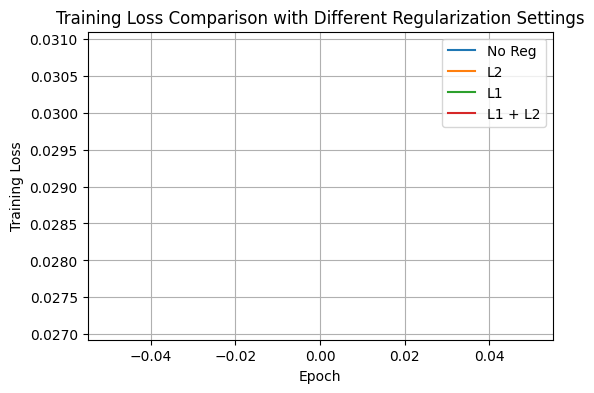

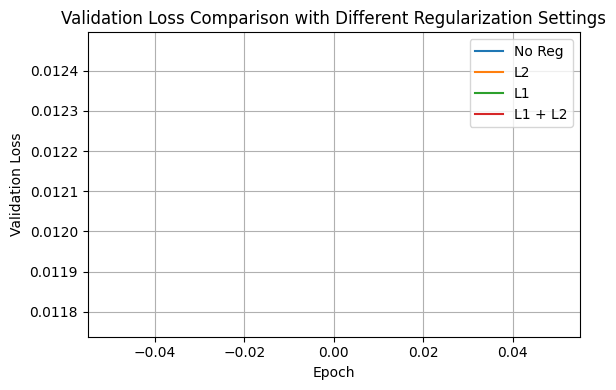

In [ ]:
# Example usage
lambda_1 = 1e-5
lambda_2 = 1e-5

train_losses = {}
val_losses = {}

# Train and save models with different regularization methods
train_losses['No Reg'], val_losses['No Reg'] = train_autoencoder(
    train_loader_noisy, val_loader_noisy, model_name='no_reg_noisy'
)
train_losses['L2'], val_losses['L2'] = train_autoencoder(
    train_loader_noisy, val_loader_noisy, lambda_2=lambda_2, model_name='l2_reg_noisy'
)
train_losses['L1'], val_losses['L1'] = train_autoencoder(
    train_loader_noisy, val_loader_noisy, lambda_1=lambda_1, model_name='l1_reg_noisy'
)
train_losses['L1 + L2'], val_losses['L1 + L2'] = train_autoencoder(
    train_loader_noisy, val_loader_noisy, lambda_1=lambda_1, lambda_2=lambda_2, model_name='l1_l2_reg_noisy'
)

# Plot all losses
plot_losses({
    'train': train_losses,
    'val': val_losses
})

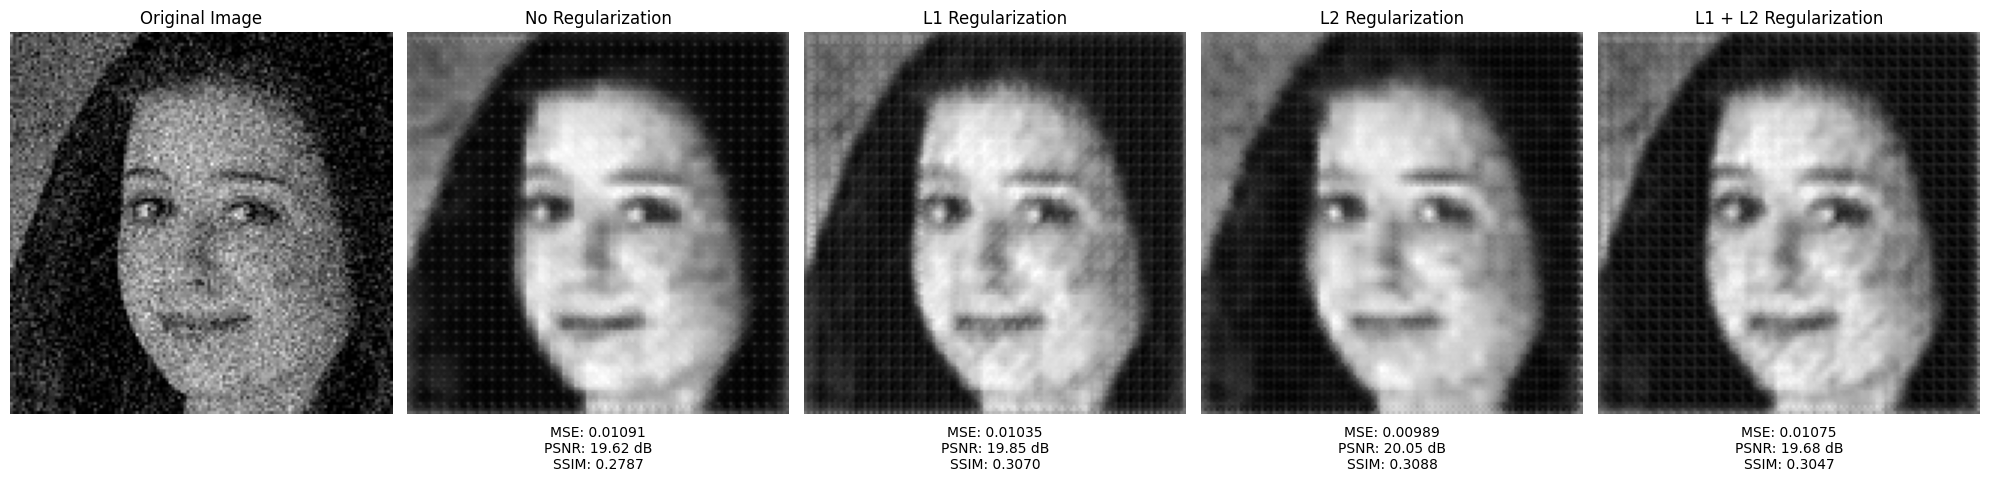

In [ ]:
# List of model paths and titles for plots
model_paths = [
    'autoencoder_best_no_reg_noisy',
    'autoencoder_best_l1_reg_noisy',
    'autoencoder_best_l2_reg_noisy',
    'autoencoder_best_l1_l2_reg_noisy'
]
titles = [
    'No Regularization',
    'L1 Regularization',
    'L2 Regularization',
    'L1 + L2 Regularization'
]

# Plot for a specific image index, e.g., 0
plot_single_image_reconstructions(0, model_paths, titles, test_loader_noisy)


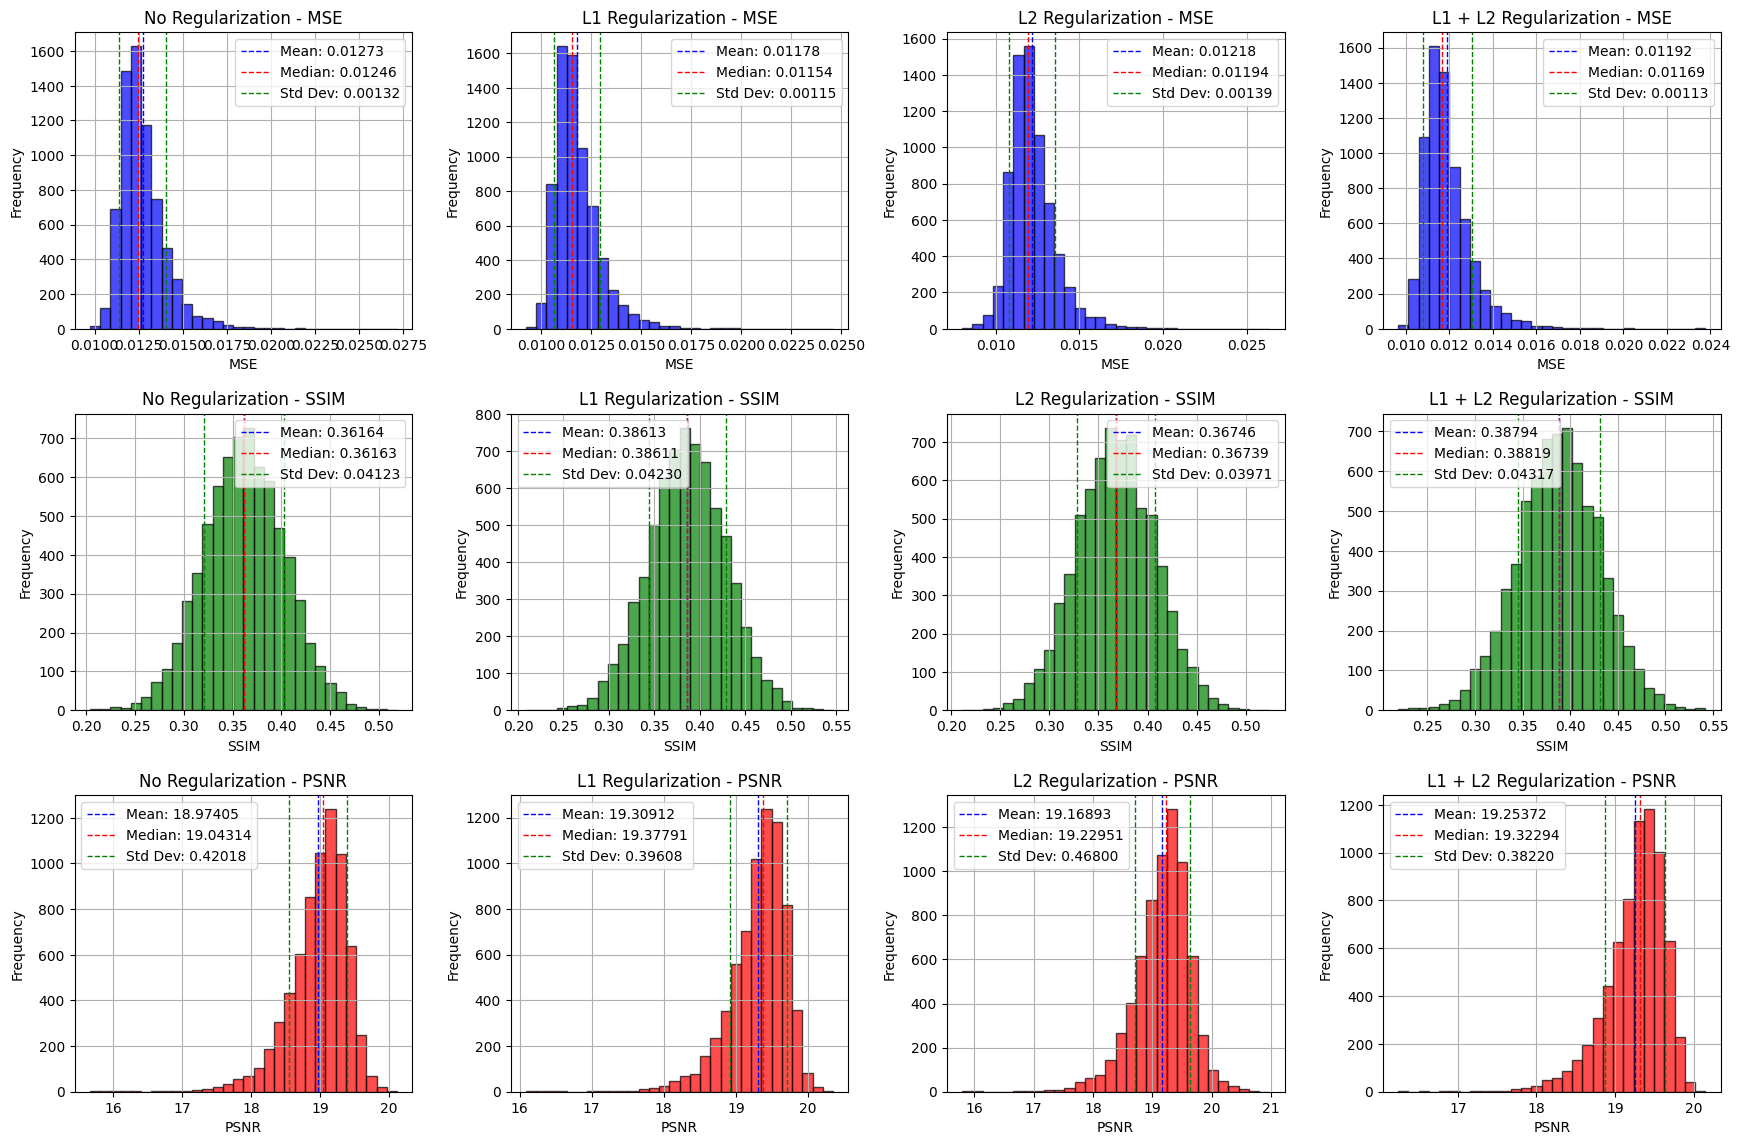

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of model paths and titles for plots
model_paths = [
    'autoencoder_best_no_reg',
    'autoencoder_best_l1_reg_noisy',
    'autoencoder_best_l2_reg_noisy',
    'autoencoder_best_l1_l2_reg_noisy'
]
titles = [
    'No Regularization',
    'L1 Regularization',
    'L2 Regularization',
    'L1 + L2 Regularization'
]

# Create a figure with subplots for each model
fig, axes = plt.subplots(3, len(model_paths), figsize=(18, 12))
fig.tight_layout(pad=4.0)

for idx, (model_path, title) in enumerate(zip(model_paths, titles)):
    # Initialize lists to store metrics for this model
    mse_list = []
    ssim_list = []
    psnr_list = []

    # Load and evaluate the model
    model = ConvAutoEncoder().to(device)
    model.load_state_dict(torch.load(f'./{model_path}.pth'))
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader_noisy):
            images, _ = batch
            images = images.to(device)  # Images should already be in shape (batch_size, channels, height, width)
            
            # Reconstruct images
            reconstructed_images = model(images)  # Adjust according to your ConvAutoEncoder output
            
            # Convert images and reconstructed images to numpy arrays
            original_images = images.cpu().numpy()  # Shape should be (batch_size, 1, height, width)
            reconstructed_images = reconstructed_images.cpu().numpy()  # Shape should be (batch_size, 1, height, width)

            # Calculate metrics
            mse, ssim_values, psnr_values = calculate_metrics(original_images, reconstructed_images)
            mse_list.extend(mse)
            ssim_list.extend(ssim_values)
            psnr_list.extend(psnr_values)

    # Ensure all lists have the same length
    min_length = min(len(mse_list), len(ssim_list), len(psnr_list))
    mse_list = mse_list[:min_length]
    ssim_list = ssim_list[:min_length]
    psnr_list = psnr_list[:min_length]

    # Plot histograms for MSE, SSIM, and PSNR in respective rows
    ax_mse = axes[0, idx]
    ax_ssim = axes[1, idx]
    ax_psnr = axes[2, idx]

    # MSE Plot
    plot_histogram_with_stats(ax_mse, mse_list, 'blue', 'MSE', 'Frequency')
    ax_mse.set_title(f'{title} - MSE')

    # SSIM Plot
    plot_histogram_with_stats(ax_ssim, ssim_list, 'green', 'SSIM', 'Frequency')
    ax_ssim.set_title(f'{title} - SSIM')

    # PSNR Plot
    plot_histogram_with_stats(ax_psnr, psnr_list, 'red', 'PSNR', 'Frequency')
    ax_psnr.set_title(f'{title} - PSNR')

plt.show()  # Display the combined plot
